<a href="https://colab.research.google.com/github/nikopj/SummerML/blob/master/Day2/Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 2: Linear Regression

## Outline:
- Motivating Example
- Linear Model
- Least Squares Fit Problem
- Sample Mean and Variance
- LS Fit Solution
- Goodness of Fit
- Multivariable Linear Regression
- Scikit-learn

## Linear Model
Estimate the relationship seen in the data via $\hat{y} = \beta_0 + \beta_1x$, where *we* need to determine our parameters $\beta = (\beta_0, \beta_1)$, ie. our slope and intercept.

### Reading & Visualizing the Data
We'll look at virus inactivation in wetland waters due to sunlight.


##### For loading in local files, [source](https://colab.research.google.com/notebooks/io.ipynb) 

In [0]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving data2.csv to data2 (5).csv


In [0]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded[filename]))
df

,Time (h),Ct1 Clear,Ct1 5cm,Ct1 20cm,Ct2 Clear,Ct2 5cm,Ct2 20cm
0,0.00,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
1,0.75,NaN,547323.127588,680310.384129,NaN,427843.265172,724747.957348
2,1.00,124572.849877,NaN,NaN,124242.476640,NaN,NaN
3,1.50,NaN,191599.336146,434275.771006,NaN,163016.250572,491827.603978
4,2.00,23632.953475,NaN,NaN,28479.804254,NaN,NaN
5,2.25,NaN,66699.257600,267168.775510,NaN,60215.597490,224766.301820
6,3.00,2364.275054,21358.069727,123072.776978,3703.735805,15289.278797,112632.545682
7,4.00,472.992223,4481.980885,69507.072936,569.997564,3151.417918,33667.665216


### Explanation of Data & Visualization
The data shows the number of active viruses in clear and wetland waters, where the wetland water measurements are taken at two different depths, 5cm and 20cm. Exposure to sunlight over a period of time should render the viruses inactive. We should see that as we go deeper into the water, less sunlight can penetrate and so viral activity decreases at a slower rate. Lets find the rates! 

---

Notice that the maximum concentration across the board is $10^6$ [units?]. Let's normalize the data by dividing all our results by $C_0 =10^6$.

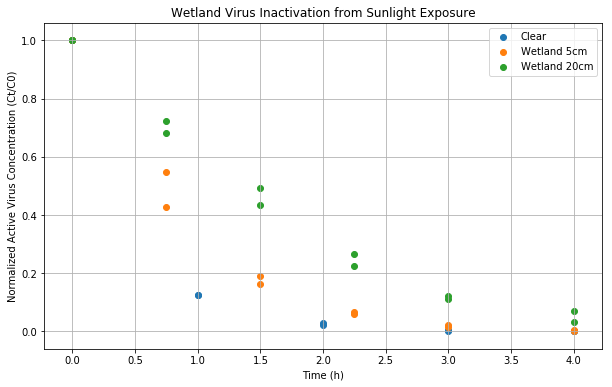

In [0]:
# let's convert our imported data into numpy arrays for easy handling
import numpy as np

c0 = 1e6 # normalization constant

time = df['Time (h)'].values # time is our feature variable
# ct variables, virus concentratoin, are our target variables on which we'll perform regression
ct1_clear = df['Ct1 Clear'].values / c0
ct2_clear = df['Ct2 Clear'].values / c0
ct1_5cm   = df['Ct1 5cm'].values / c0
ct2_5cm   = df['Ct2 5cm'].values / c0
ct1_20cm  = df['Ct1 20cm'].values / c0
ct2_20cm  = df['Ct2 20cm'].values / c0

# we can concatenatve the trials (if we also concatenate time trials)
cat_time = np.concatenate((time,time))
ct_clear = np.concatenate((ct1_clear,ct2_clear))
ct_5cm   = np.concatenate((ct1_5cm,ct2_5cm))
ct_20cm   = np.concatenate((ct1_20cm,ct2_20cm))

# let's also take not of the NaN locations in the data so we don't run into trouble later
# Notice that the Clear values share the same NaN locations, and so do the 5/20cm
nanloc_clear = np.isnan(ct_clear)
nanloc_wetla = np.isnan(ct_5cm)

# import the matplotlib package from plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# lets plot the data
plt.rcParams['figure.figsize'] = [10, 6] # sets the figure size
# remember to remove NaN locations when plotting

plt.scatter(cat_time[~nanloc_clear], ct_clear[~nanloc_clear])
plt.scatter(cat_time[~nanloc_wetla], ct_5cm[~nanloc_wetla])
plt.scatter(cat_time[~nanloc_wetla], ct_20cm[~nanloc_wetla])
plt.grid(True)
plt.legend(['Clear','Wetland 5cm','Wetland 20cm'])
plt.title('Wetland Virus Inactivation from Sunlight Exposure')
plt.xlabel('Time (h)')
plt.ylabel('Normalized Active Virus Concentration (Ct/C0)');

### Can you postulate a model for the data?
- What would a simple linear model look like?


## Crude Estimate

We can form a crude estimate by using the first and last points of the data to form a line. In this case, $\beta_0 = c_a - \beta_1 t_a $ and $\beta_1 = \frac{c_b - c_a}{t_b - t_a}$, where we choose $a,b$ by inspection. (We're converting point slope form to point-intercept for the parameter estimates)

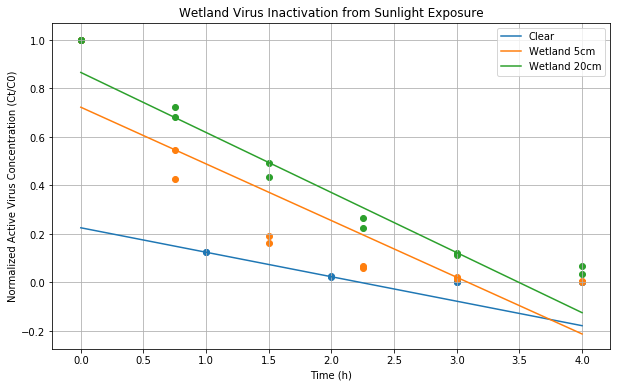

In [0]:
# A crude estimate for the slope of the lines

# slope parameter beta_1
b1_clear = ( ct_clear[4] - ct_clear[2] ) / (time[4] - time[2]) 
b1_5cm   = ( ct_5cm[6] - ct_5cm[1] ) / (time[6] - time[1])
b1_20cm   = ( ct_20cm[6] - ct_20cm[1] ) / (time[6] - time[1])

# intercept parameter beta_0
b0_clear = ct_clear[2] - b1_clear*time[2]
b0_5cm = ct_5cm[1] - b1_5cm*time[1]
b0_20cm = ct_20cm[1] - b1_20cm*time[1]

plt.rcParams['figure.figsize'] = [10, 6] # sets the figure size
# remember to remove NaN locations when plotting

plt.scatter(cat_time[~nanloc_clear], ct_clear[~nanloc_clear])
plt.scatter(cat_time[~nanloc_wetla], ct_5cm[~nanloc_wetla])
plt.scatter(cat_time[~nanloc_wetla], ct_20cm[~nanloc_wetla])

# Crude Estimates
t = np.array([0,4])
est_clear = b1_clear*t + b0_clear
est_5cm = b1_5cm*t + b0_5cm
est_20cm = b1_20cm*t + b0_20cm

plt.plot(t, est_clear)
plt.plot(t, est_5cm)
plt.plot(t, est_20cm)

plt.grid(True)
plt.legend(['Clear','Wetland 5cm','Wetland 20cm'])
plt.title('Wetland Virus Inactivation from Sunlight Exposure')
plt.xlabel('Time (h)')
plt.ylabel('Normalized Active Virus Concentration (Ct/C0)');

## Can we base our model off of all data, not just two points? --> Least Squares fit
We introduce an error function to our model, and base our parameters off of minimizing the error. In this case, we use $$ E = \sum_{i=0}^{N-1} (y_i-\hat{y}_i)^2 = \sum_{i=0}^{N-1} (y_i-\beta_0 - \beta_1 x_i)^2 $$ where $N$ is the number of data points, $y_i, \hat{y}_i$ are our $i$th data points and model predictions respectively, and $x_i$ is our $i$th model input.


---

The the optimal least squares beta parametres can be determined analytically with calculus. Many python packages can solve for the $\beta$ parameters of the least squares solution automatically, but to interpret them we should be familiar with some statistics.

## Sample Mean & Variance (see slides)

## Least-Squares Fit Solution
For linear regression of a single variable, there is a simple closed-form solution.

Our model is: y = beta0 + beta1 * x

The parameters beta0 and beta1 can be calculated through two equations as shown in the slides.

Here we calculate the two parameters for our data set. 

We will consider only the clear-water viral concentration now for demonstration purposes.

In [0]:
# let x = time, y = clear water data
x = cat_time[~nanloc_clear]
y = ct_clear[~nanloc_clear]

# Calculate the mean of x and y
xm = np.mean(x)        
ym = np.mean(y)        

syy = np.mean((y-ym)**2)        # Variance of y    
syx = np.mean((y-ym)*(x-xm))    # Covariance of x and y
sxx = np.mean((x-xm)**2)        # Variance of x

beta1 = syx/sxx
beta0 = ym - beta1*xm
print('beta0 = {:.2f}, beta1 = {:.2f}'.format(beta0,beta1))

beta0 = 0.65, beta1 = -0.21


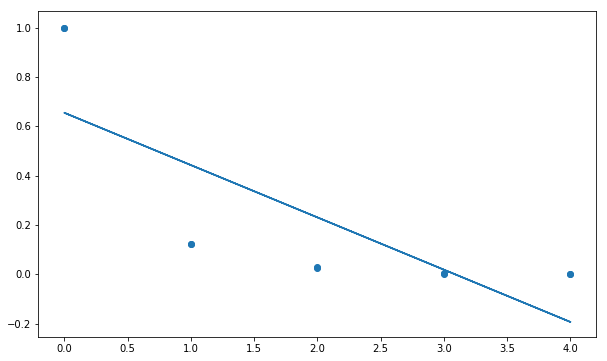

In [0]:
y_hat = beta0 + beta1*x         # Use the calculated parameters to predict y

plt.scatter(x,y)
plt.plot(x,y_hat);

We may also formulate this in a linear-algebraic way in which we're finding the optimal $\beta$ that solves $$ A\beta = \mathbf{y} + \epsilon $$ (a matrix equation). Where $A$ is called the **design matrix** and encodes the model. For the linear model, the $n$th row of $A$, $$a_n = x_n^0 + x_n^1 = 1 + x_n$$ 

The matrix equation is then solved in the least-squares sense using the *Moore-Penrose Psuedo Inverse*, $$ \beta = A^\dagger \mathbf{y}  $$ 

### Continuing with Wetlands examples
We can form design matricies for our wetlands data.

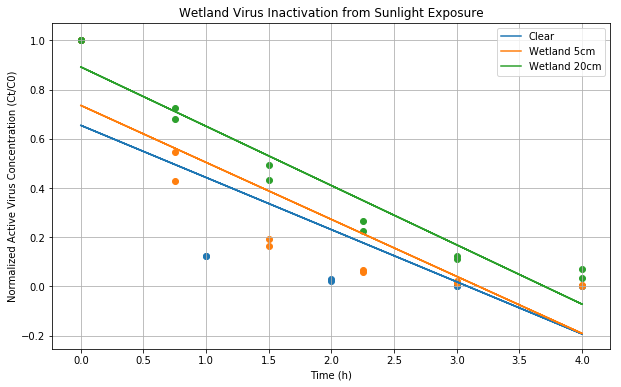

In [0]:
def linreg(x,y, plot=False):
  ones = np.ones((len(x),1))
  # design matrix with model: yhat = beta0 + beta1*x
  A = np.hstack((ones,x))
  soln = np.linalg.lstsq(A,y,rcond=None)
  beta = soln[0]
  y_hat = beta[0] + beta[1]*x  # Use the calculated parameters to predict y
  # plotting
  if(plot):
    plt.scatter(x,y)
    plt.plot(x,y_hat)
  return beta, y_hat
  
# let x = time, y = clear water data
x = cat_time[~nanloc_clear].reshape(-1,1)
y = ct_clear[~nanloc_clear].reshape(-1,1)
linreg(x,y,plot=True) 
 
# let x = time, y = 5cm wetland water data
x = cat_time[~nanloc_wetla].reshape(-1,1)
y = ct_5cm[~nanloc_wetla].reshape(-1,1)
linreg(x,y,plot=True)

# let x = time, y = 20cm wetland water data
x = cat_time[~nanloc_wetla].reshape(-1,1)
y = ct_20cm[~nanloc_wetla].reshape(-1,1)
linreg(x,y,plot=True)

# plotting nicely
plt.grid(True)
plt.legend(['Clear','Wetland 5cm','Wetland 20cm'])
plt.title('Wetland Virus Inactivation from Sunlight Exposure')
plt.xlabel('Time (h)')
plt.ylabel('Normalized Active Virus Concentration (Ct/C0)');

## Goodness of Fit
To determine whether our model is a good fit for the dataset, we use the R^2 score as a measure of goodness of fit.

R^2 score returns a number between 0 and 1. R^2 close to 1 means that the linear model is a good fit. R^2 close to 0 means that the linear model is a poor fit. 

In [0]:
RSS = np.sum((y - y_hat)**2)
N = y.size    # Number of samples in the data set
R2 = 1 - (RSS/N)/syy
print('R^2 = {:.2f}'.format(R2))

R^2 = 0.60


## Don't Turn Off Your Brain!
- Does a linear model make sense for the wetlands data?
-  Why does our model predict negative concentrations at certain times?
- What does this mean?

### Answer: exponential decay
Concentration rates often correspond to exponential decay, $$ c(t) = c_0 e^{-\alpha t}$$ where $c_0$ is our initial concentration and $\alpha$ is our rate of decay. If we transform the data to $$ln(c(t)/c_0) = -\alpha t$$ we can still use our linear model to find the rate of decay. In this specific case, we want to force the bias term of the moel, $\beta_0$ to *zero* so that the initial concentration is always $c_0$.

R2 values
0.999
0.978
0.967


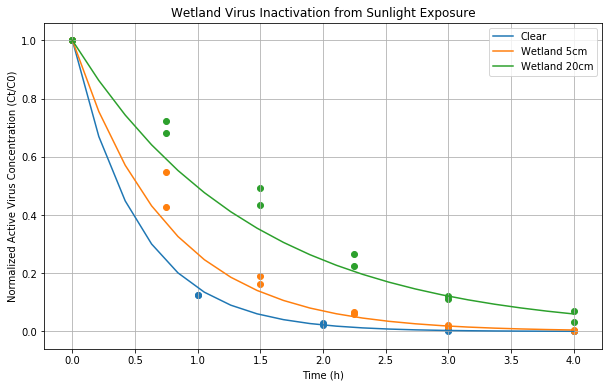

In [0]:
# updated regression function to force bias term to zero
def linreg_exp(x,y,plot=False):
  # design matrix with model: yhat = beta0*x
  A = x
  soln = np.linalg.lstsq(A,-np.log(y),rcond=None)
  beta = soln[0]
  y_hat = np.exp(-beta*x)  # Use the calculated parameters to predict y
  # plotting
  if(plot):
    # scatter original data
    plt.scatter(x,y)
    # plot model
    x2 = np.linspace(np.min(x),np.max(x),20).reshape(-1,1)
    y_plot = np.exp(-beta*x2)
    plt.plot(x2,y_plot)
  RSS = np.sum((y - y_hat)**2)
  N = y.size    # Number of samples in the data set
  R2 = 1 - (RSS/N)/syy
  return beta, y_hat, R2

arr_R2 = []

# let x = time, y = clear water data
x = cat_time[~nanloc_clear].reshape(-1,1)
y = ct_clear[~nanloc_clear].reshape(-1,1)
_,_,r = linreg_exp(x,y,plot=True)
arr_R2.append(r)
 
# let x = time, y = 5cm wetland water data
x = cat_time[~nanloc_wetla].reshape(-1,1)
y = ct_5cm[~nanloc_wetla].reshape(-1,1)
_,_,r = linreg_exp(x,y,plot=True)
arr_R2.append(r)

# let x = time, y = 20cm wetland water data
x = cat_time[~nanloc_wetla].reshape(-1,1)
y = ct_20cm[~nanloc_wetla].reshape(-1,1)
_,_,r = linreg_exp(x,y,plot=True)
arr_R2.append(r)

# plotting nicely
plt.grid(True)
plt.legend(['Clear','Wetland 5cm','Wetland 20cm'])
plt.title('Wetland Virus Inactivation from Sunlight Exposure')
plt.xlabel('Time (h)')
plt.ylabel('Normalized Active Virus Concentration (Ct/C0)');

### New model based on transformed data improves squared error


In [0]:
print("R2 values")
for val in arr_R2:
  print('{:.3f}'.format(val))

R2 values
0.999
0.978
0.967


## Multivariable Linear Regression
In multivariable linear regression, we try to use more than one features to predict the output.
Again we use a linear model where the output is a linear combination of the input features (plus a bias beta0).

We need to calculate the parameters beta0, beta1, beta2,.... for the equation: 

y_hat = beta0 + beta1 * x1 + beta2 * x2 + ...

We can use numpy or sklearn to solve the multivariable least squares problem.

In [0]:
import pandas as pd
import numpy as np

# Housing Dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', 
                 header=None,delim_whitespace=True,na_values='?')

Xy = df.values               # take out the data matrix
y = Xy[:,-1]                 # the last column is the housing price: the y that we want to predict
X = Xy[:,0:-1]               # Rest of the columns are input X, each column is a feature
y = y.reshape(-1,1)          # Reshape y to a column vector
print(X.shape,y.shape)

(506, 13) (506, 1)


We can see that there are 506 sample points in this data set. 
And for each sample, there are 13 features.


In [0]:

ones = np.ones((X.shape[0],1))
A = np.hstack((ones,X))           # Concatenate a column of 1's to the X matrix
out = np.linalg.lstsq(A,y,rcond=None)        # Use numpy to solve the least squares problem
beta = out[0]                     # The first element in the returned list is the beta vector
beta = beta.reshape(-1,1)         # reshape beta so that it is a column vector
print(beta.shape)

(14, 1)


The output beta vector has a length of 14, which gives us the 14 parameters we want. 13 parameters for 13 features, plus one bias.

In [0]:
y_hat = A.dot(beta)       # Matrix multiplication between the data matrix A and beta vector gives us 
RSS = np.mean((y_hat-y)**2)/(np.std(y))**2
R2 = 1 - RSS
print('R^2 = {:.3f}'.format(R2))

R^2 = 0.741


#### Using Scikit-Learn
Scikit-learn is a Python library for machine learning. It provides many machine learning algorithms including linear regression.

In [0]:
from sklearn import linear_model
regr = linear_model.LinearRegression()         # Initilize a linear regression model
regr.fit(X,y)                                  # Use the fit method to fit data onto the model
y_hat_sk = regr.predict(X)                     # Use the model to predict
y_hat_sk = y_hat_sk.reshape(-1,1)
RSS_sk = np.mean((y_hat_sk-y)**2)/(np.std(y))**2    # Calculate the R^2 score
R2_sk = 1 - RSS_sk
print('R^2 = {:.3f}'.format(R2_sk))

R^2 = 0.741
